In [15]:
import numpy as np
import subprocess

prefix = 'AcousticMonopole'
forwardFile = prefix+'.forward_run.txt'
adjointFile = prefix+'.adjoint_run.txt'

In [16]:
def QoI(forwardOutputFile, finalConditionFile):
    fQoI0 = open(forwardOutputFile,'r')
    QoI0 = float(fQoI0.read())
    fQoI0.close()
    
    targetFile = prefix+'-00000006.q'
    diffFile = prefix+'.diff.1.q'
    subprocess.check_call('./qfile_zaxpy ' + diffFile + ' ' + \
                      "{:.16E}".format(-1.0) + ' ' + finalConditionFile + \
                      ' ' + targetFile, shell=True)
    
    diffOutput = prefix+'.diff.1.txt'
    subprocess.check_call('./spatial_inner_product '+diffFile+' '+diffFile + \
                          ' --output ' + diffOutput, shell=True)
    fID = open(diffOutput,'r')
    diffQoI = float(fID.read())
    fID.close()
    
    w = 1.0e-6
    
    return QoI0 + w * 0.5 * diffQoI

In [17]:
ic0File = prefix+'.ic.0.q'
icFile = prefix+'.ic.q'
subprocess.check_call('cp '+ic0File+' '+icFile, shell=True)
subprocess.check_call('./forward --output '+forwardFile, shell=True)

fcFile = prefix+'-00000006.fc.q'
QoI0 = QoI(forwardFile, fcFile)
print ("QoI0: ", QoI0)

QoI0:  0.0016277912399411526


In [18]:
# First intermediate adjoint
# NOTE: change magudi.inp setup!!

subprocess.check_call('./adjoint --output '+adjointFile, shell=True)
fGrad0 = open(adjointFile,'r')
Grad0 = float(fGrad0.read())
fGrad0.close()
print ("Grad0: ", Grad0)

Grad0:  3.845137485220697e-21


In [19]:
# Second intermediate adjoint
# NOTE: change magudi.inp setup!!

dt = 1.0e-3
w = 1.0e-6

resultAdjointFile = prefix + '-00000006.adjoint.diff_added.q'
targetAdjointFile = prefix + '-00000006.adjoint.q'
diffFile = prefix+'.diff.1.q'
subprocess.check_call('./qfile_zaxpy ' + resultAdjointFile + ' ' + \
                  "{:.16E}".format(w) + ' ' + diffFile + \
                  ' ' + targetAdjointFile, shell=True)
subprocess.check_call('mv ' + resultAdjointFile + ' ' + \
                  targetAdjointFile, shell=True)

subprocess.check_call('./adjoint --output '+adjointFile, shell=True)
fGrad0 = open(adjointFile,'r')
Grad0 = float(fGrad0.read())
fGrad0.close()
print ("Grad0: ", Grad0)

Grad0:  9.95738959048514e-19


In [20]:
ic_grad_file = prefix + '-00000000.adjoint.q'
grad_norm_file = prefix + '.spatial_inner_product.txt'
subprocess.check_call('mpirun -n 2 ./spatial_inner_product '+ic_grad_file+' '+ic_grad_file, shell=True)
fQoI0 = open(grad_norm_file,'r')
icGrad0 = float(fQoI0.read())
fQoI0.close()
print ("ic_grad0: ", icGrad0)

ic_grad0:  3.752808318713404e-09


In [62]:
grad_norm_file = prefix + '.spatial_inner_product.txt'
subprocess.check_call('mpirun -n 2 ./spatial_inner_product '+diffFile+' '+diffFile, shell=True)
fQoI0 = open(grad_norm_file,'r')
matchGrad0 = w*w*float(fQoI0.read())
fQoI0.close()
print ("match_grad0: ", matchGrad0)

match_grad0:  3.0299224497818367e-09


In [59]:
Nk = 20
# Ak = np.zeros((Nk,),dtype=np.double)
Ak = 10.0**(11.0-0.25*np.array(range(Nk)))
QoIk = np.zeros((Nk,),dtype=np.double)
Gradk = np.zeros((Nk,),dtype=np.double)
ek = np.zeros((Nk,),dtype=np.double)

forwardFile = prefix+'.forward_run.txt'

In [51]:
# solution zaxpy test
zfile = icFile
xfile = ic_grad_file
yfile = ic0File
subprocess.check_call('./qfile_zaxpy ' + zfile + " " + \
                      "{:.16E}".format(0.0e-3) + ' ' + \
                      xfile + ' ' + yfile, shell=True)

0

In [64]:
forwardFile1 = prefix+'.forward_run.1.txt'
baseline_control_forcing_file = ['']
grad_file = [prefix+'.gradient_controlRegion.dat']
control_forcing_file = [prefix+'.control_forcing_controlRegion.dat']

w2 = 1.0e-10
Grad = Grad0 + icGrad0 * w2 + matchGrad0 * w2
# Grad = Grad0
# Grad = icGrad0 * w2

fc1File = prefix+'-00000006.fc.1.q'

fId = open(prefix+'.gradient_accuracy.txt','w')
for k in range(Nk):
    actuation_amount = Ak[k]
    i = 0
    command = './zaxpy '+control_forcing_file[i]+' '+"{:.16E}".format(actuation_amount)+' '+grad_file[i]+' '+baseline_control_forcing_file[i]
    subprocess.check_call(command, shell=True)
    command = 'mpirun -n 2 ./qfile_zaxpy '+zfile+' '+"{:.16E}".format(actuation_amount*w2)+' '+xfile+' '+yfile
    subprocess.check_call(command, shell=True)
    command = 'mpirun -n 2 ./qfile_zaxpy '+fc1File+' '+"{:.16E}".format(actuation_amount*w2*(-w))+' '+diffFile+' '+fcFile
    subprocess.check_call(command, shell=True)
    subprocess.check_call('./forward --output '+forwardFile1, shell=True)
    QoIk[k] = QoI(forwardFile1, fc1File)

    Gradk[k] = (QoIk[k]-QoI0)/Ak[k]
    ek[k] = abs( (Gradk[k]-Grad)/Grad )
    fId.write("{:.16E}".format(actuation_amount)+'\t'
                +"{:.16E}".format(QoIk[k])+'\t'
                +"{:.16E}".format(Gradk[k])+'\t'
                +"{:.16E}".format(ek[k]))
    print ("{:.16E}".format(actuation_amount), "{:.16E}".format(QoIk[k]), "{:.16E}".format(Gradk[k]), "{:.16E}".format(ek[k]))

fId.close()

1.0000000000000000E+11 1.6279586502940184E-03 1.6741035286575549E-18 5.4654779986551024E-05
5.6234132519034904E+10 1.6278853802922711E-03 1.6740784804785107E-18 3.9691817649950625E-05
3.1622776601683792E+10 1.6278441780313532E-03 1.6740494001309261E-18 2.2320169799717045E-05
1.7782794100389229E+10 1.6278210089261454E-03 1.6740330470414170E-18 1.2551369362005293E-05
1.0000000000000000E+10 1.6278079801796633E-03 1.6740238510714115E-18 7.0579978638624062E-06
5.6234132519034910E+09 1.6278006536399807E-03 1.6740186798227128E-18 3.9688631457042442E-06
3.1622776601683793E+09 1.6277965336438304E-03 1.6740157717634033E-18 2.2316836947147570E-06
1.7782794100389228E+09 1.6277942168060233E-03 1.6740141363075414E-18 1.2547158911233004E-06
1.0000000000000000E+09 1.6277929139543702E-03 1.6740132175417643E-18 7.0587528701425103E-07
5.6234132519034910E+08 1.6277921813076719E-03 1.6740126984665201E-18 3.9579672538700106E-07
3.1622776601683795E+08 1.6277917693103567E-03 1.6740124080146571E-18 2.222902888

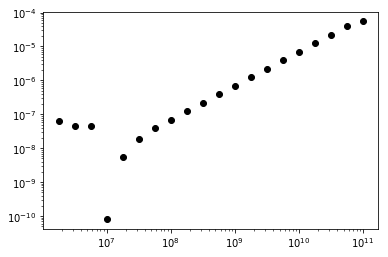

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
plt.loglog(Ak,ek,'ok')